In [294]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import imgaug.augmenters as iaa
import time

from keras import layers
from keras.datasets import mnist
from keras.models import Model

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [295]:
def add_gaussian_noise(images):
    """Adds additive Gaussian noise to all images in the supplied array."""
    
    seq = iaa.AdditiveGaussianNoise(scale=(25, 35))
    augmented_images = seq.augment_images(images)
    return augmented_images

def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1)
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2)
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [296]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
print('Sample dims: ', train_images.shape)
print('Test samples: ', test_images.shape)

Sample dims:  (50000, 32, 32, 3)
Test samples:  (10000, 32, 32, 3)


In [297]:
#augmentation block
train_images_aug = []
train_labels_aug = []

augmentations = (
    iaa.Fliplr(1),
    iaa.Flipud(1),
    iaa.Affine(rotate=(-30))
)
  
#define amount of augmented images
num_augmented_samples = int(0.4 * len(train_images))

#Augmentation
for i in range(num_augmented_samples):
    random_aug = np.random.randint(0, 3)
    seq = iaa.Sequential(augmentations[random_aug])
    augmented_image = seq.augment_image(train_images[i])
    train_images_aug.append(np.expand_dims(augmented_image, axis=0))
    train_labels_aug.append(train_labels[i])


# fusion train and augmented
train_images_aug = np.concatenate(train_images_aug, axis=0)
train_labels_aug = np.array(train_labels_aug)
train_images = np.concatenate((train_images, train_images_aug))
train_labels = np.concatenate((train_labels, train_labels_aug))

print('Sample dims: ', train_images.shape)
print('Test samples: ', test_images.shape)

Sample dims:  (70000, 32, 32, 3)
Test samples:  (10000, 32, 32, 3)


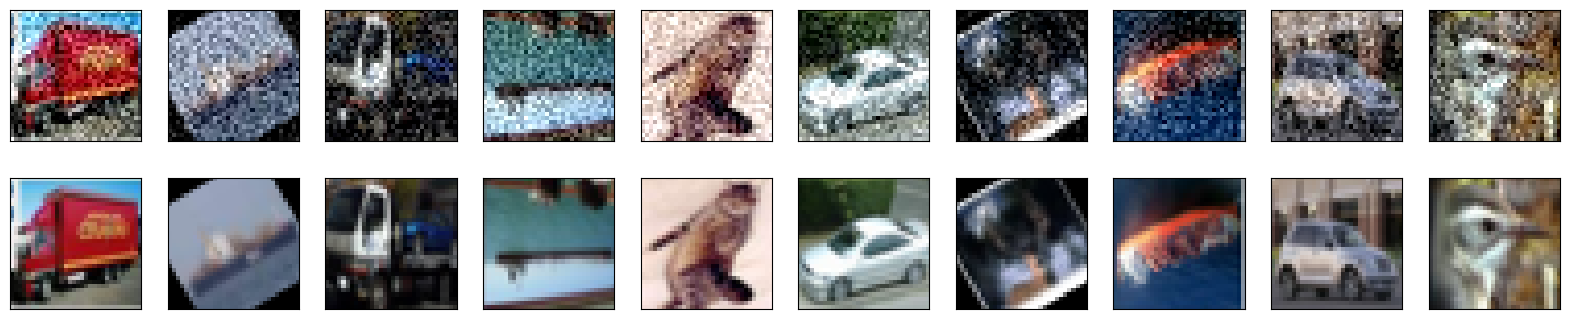

In [298]:

# Mapping from class ID to class name
classes = {0:'plane', 1:'car', 2:'bird', 3:'cat', 4:'deer',
           5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

# Dataset params
num_classes = len(classes)
shape = train_images.shape

height = shape[1]
width = shape[2]

# Shuffle the training data (optional but recommended)
train_images, train_labels = shuffle(train_images, train_labels)

#Let's blur our images
noisy_train_data = add_gaussian_noise(train_images)
noisy_test_data = add_gaussian_noise(test_images)

#Show result
display(noisy_train_data, train_images)

In [299]:
train_images = np.array(train_images) / 255.0
test_images = np.array(test_images) / 255.0

input = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="MSE", metrics=["accuracy"])
autoencoder.summary()

Model: "functional_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_34 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 32, 32, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 16, 16, 32)     │        73,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_68             │ (None, 16, 16, 256)    │        73,984 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_69             │ (None, 32, 32, 32)     │        73,760 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 229,539 (896.64 KB)

 Trainable params: 229,539 (896.64 KB)

 Non-trainable params: 0 (0.00 B)

In [300]:
# epochs = 5
# batch_size = 256
# steps_per_epoch = len(noisy_train_data) // batch_size
# history = autoencoder.fit(train_images, train_images,  batch_size=batch_size, epochs=epochs, validation_data=(test_images, test_images))

In [301]:
# def plot_history(history):
#     h = history.history
#     epochs = range(len(h['loss']))

#     plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
#     plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
#     plt.legend(['Train', 'Validation'])
#     plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
#                                epochs, h['val_accuracy'], '.-')
#     plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
#     plt.legend(['Train', 'Validation'])
        
#     print('Train Acc     ', h['accuracy'][-1])
#     print('Validation Acc', h['val_accuracy'][-1])
    
# plot_history(history)

In [302]:
# predictions = autoencoder.predict(test_images)
# display(test_images, predictions)

In [303]:
epochs = 5
batch_size = 256
steps_per_epoch = len(noisy_train_data) // batch_size
history = autoencoder.fit(noisy_train_data, train_images,  batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 91s 408ms/step - accuracy: 0.4275 - loss: 0.0492 - val_accuracy: 0.5738 - val_loss: 0.0169
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 88s 399ms/step - accuracy: 0.5892 - loss: 0.0165 - val_accuracy: 0.5633 - val_loss: 0.0180
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 88s 402ms/step - accuracy: 0.6223 - loss: 0.0146 - val_accuracy: 0.6621 - val_loss: 0.0144
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 88s 402ms/step - accuracy: 0.6568 - loss: 0.0132 - val_accuracy: 0.6635 - val_loss: 0.0124
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 87s 397ms/step - accuracy: 0.6664 - loss: 0.0130 - val_accuracy: 0.6690 - val_loss: 0.0120


Train Acc      0.6691411137580872
Validation Acc 0.6690165996551514


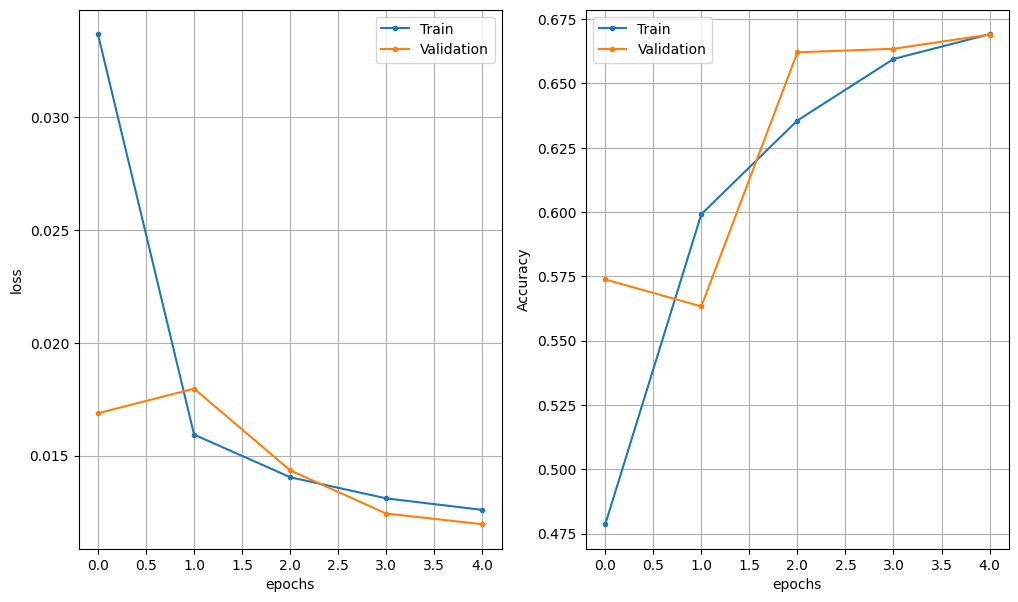

In [304]:
def plot_history(history):
    h = history.history
    epochs = range(len(h['loss']))

    plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
    plt.legend(['Train', 'Validation'])
    plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                               epochs, h['val_accuracy'], '.-')
    plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
        
    print('Train Acc     ', h['accuracy'][-1])
    print('Validation Acc', h['val_accuracy'][-1])
    
plot_history(history)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


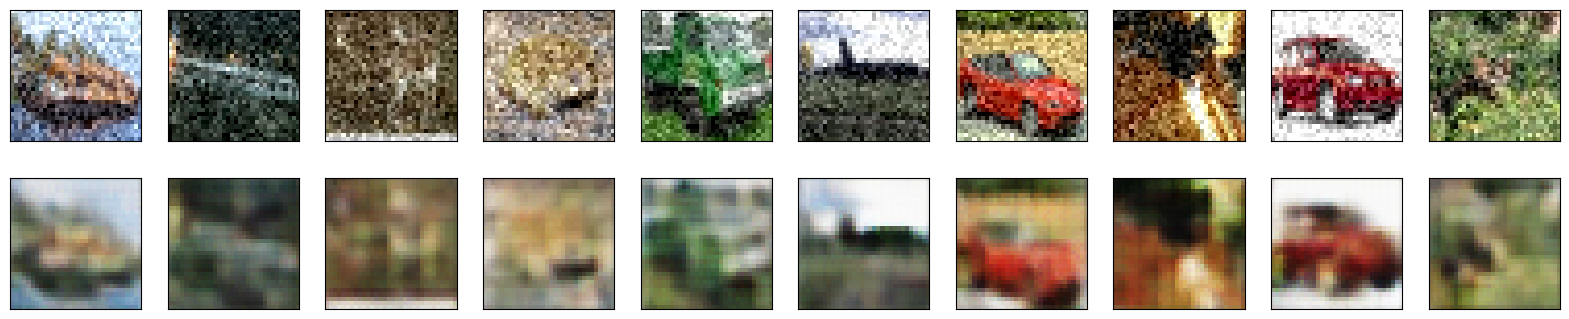

In [305]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)